# Optimización de XGBoost para el Análisis de Pymes (SME)
### Potencia y Precisión: De las Redes Neuronales al Gradient Boosting

¡Es un gusto saludarles de nuevo! En esta sesión, exploraremos **XGBoost (eXtreme Gradient Boosting)**, uno de los algoritmos más potentes y utilizados en la industria para datos estructurados.

A diferencia del MLP (que busca patrones mediante pesos sinápticos) o la SVM (que busca márgenes geométricos), XGBoost es un ensamble secuencial de árboles de decisión. Hoy aprenderemos:
1.  **La Intuición del Boosting**: Cómo el modelo aprende de sus propios errores.
2.  **Hiperparametrización Crítica**: Ajuste de la tasa de aprendizaje (Eta) y la complejidad de los árboles.
3.  **Segmentación por Probabilidad**: Cómo calificar una cartera de clientes en rangos de riesgo.

---

## 1. Nota Teórica: ¿Qué hace a XGBoost tan especial?

XGBoost pertenece a la familia del **Gradient Boosting**. Su funcionamiento se basa en tres pilares:

*   **Aprendizaje Secuencial**: A diferencia de Random Forest (donde los árboles se crean en paralelo), en XGBoost cada árbol nuevo intenta corregir los errores cometidos por los árboles anteriores.
*   **Regularización**: Incluye penalizaciones (L1 y L2) para evitar que los árboles se vuelvan demasiado complejos y memoricen el ruido (sobreajuste).
*   **Manejo de Valores Faltantes**: Es capaz de aprender por sí mismo cuál es la mejor dirección para los datos nulos.

**Dato para Posgrado**: XGBoost utiliza una expansión de Taylor de segundo orden en la función de pérdida para optimizar el objetivo, lo que lo hace mucho más rápido y preciso que el Gradient Boosting tradicional.

## 2. Configuración del Entorno

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_curve, auc, classification_report, roc_auc_score
)

# Configuración estética premium
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100
BLUE = '#003882'
VIBRANT_PURPLE = '#7153ff'

## 3. Carga y Preparación de Datos

In [3]:
# Cargar el dataset
df = pd.read_csv('../data/sme_mx.csv')

# Filtrado inicial y mapeo de target
df_filtered = df[df['altaSAT'] != 'o'].copy()
df_filtered['target'] = df_filtered['altaSAT'].map({'s': 1, 'n': 0})

cols_to_keep = [
    'edadEmprendedor', 'sexoEmprendedor', 'escolaridadEmprendedor', 
    'dependientesEconomicos', 'estadoCivil', 'familiaAyuda', 
    'antiguedadNegocio', 'giroNegocio', 'numEmpleados', 
    'ventasPromedioDiarias', 'registroVentas', 'registroContabilidad', 
    'usaCredito', 'tiempoCreditoProveedores', 'target'
]

df_model = df_filtered[cols_to_keep].dropna().copy()
X = df_model.drop(columns=['target'])
y = df_model['target']

# One-Hot Encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# Partición de datos (75% entreno, 25% validación)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.25, random_state=42, stratify=y)

print(f"Dataset listo: {X_train.shape[0]} registros para entrenamiento.")

Dataset listo: 532 registros para entrenamiento.


## 4. Pipeline y Búsqueda de Hiperparámetros\n
\n
XGBoost es robusto frente a la escala de los datos (no requiere normalización obligatoria como MLP/SVM), por lo que nuestro pipeline se centrará en la selección de variables y el clasificador.

In [4]:
pipeline = Pipeline([
    ('selector', SelectKBest(score_func=f_classif)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

param_distributions = {
    'selector__k': [10, 20, 40, 'all'],
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2], # La famosa 'eta'
    'xgb__subsample': [0.7, 0.8, 1.0],      # Porcentaje de filas a usar por árbol
    'xgb__colsample_bytree': [0.7, 0.8, 1.0] # Porcentaje de variables a usar por árbol
}

print("Iniciando RandomizedSearchCV para XGBoost...")
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions, 
    n_iter=20, 
    cv=3, 
    scoring='roc_auc', 
    random_state=42, 
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

print(f"Mejor AUC Score en validación: {random_search.best_score_:.4f}")
print(f"Mejores parámetros: {random_search.best_params_}")

Iniciando RandomizedSearchCV para XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/gus/trabajo/academia/improved-potato/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [22 24 25 27 36 37 38 48 50 51 53 55 60 61 62 64 67 74 75 79 81 85 86 87
 88 90 93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/gus/trabajo/academia/improved-potato/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [19 24 25 26 27 28 29 30 31 37 38 41 46 48 56 57 58 59 64 66 67 68 69 75
 77 79 83 85 86 87 93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/gus/trabajo/academia/improved-potato/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/gus/trabajo/academia/improved-potato/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univa

Mejor AUC Score en validación: 0.7610
Mejores parámetros: {'xgb__subsample': 0.7, 'xgb__n_estimators': 100, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.2, 'xgb__colsample_bytree': 0.8, 'selector__k': 'all'}


/Users/gus/trabajo/academia/improved-potato/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [24 25 27 37 38 48 64 67 75 79 85 86 87 93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/gus/trabajo/academia/improved-potato/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/gus/trabajo/academia/improved-potato/.venv/lib/python3.13/site-packages/xgboost/training.py:200: UserWarning: [10:03:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 5. Calificación de Datos de Validación (Scoring)\n
\n
Una vez entrenado el mejor modelo, lo aplicaremos sobre el set de prueba para obtener las probabilidades y clasificar a las PyMEs en 5 rangos de riesgo/formalidad.

In [5]:
best_model = random_search.best_estimator_

# Predecimos probabilidades sobre el set de prueba
y_probs = best_model.predict_proba(X_test)[:, 1]

# Creamos el DataFrame de resultados
results_df = X_test.copy()
results_df['Actual_Target'] = y_test.values
results_df['Probabilidad_Evento'] = y_probs

# Definimos los 5 rangos de calificación
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['Muy Baja', 'Baja', 'Media', 'Alta', 'Muy Alta']
results_df['Rango_Probabilidad'] = pd.cut(results_df['Probabilidad_Evento'], bins=bins, labels=labels)

# Mostramos la tabla resumen por rangos
summary_table = results_df.groupby('Rango_Probabilidad', observed=False).agg({
    'Actual_Target': ['count', 'sum', 'mean']
}).reset_index()

summary_table.columns = ['Rango', 'Total_Clientes', 'Eventos_Reales (s)', 'Tasa_de_Evento']
summary_table['%_del_Total'] = (summary_table['Total_Clientes'] / summary_table['Total_Clientes'].sum()) * 100

print("--- Tabla de Calificación por Rangos de Probabilidad ---")
display(summary_table)

print("--- Primeros 10 registros calificados ---")
display(results_df[['Probabilidad_Evento', 'Rango_Probabilidad', 'Actual_Target']].head(10))

--- Tabla de Calificación por Rangos de Probabilidad ---


,Rango,Total_Clientes,Eventos_Reales (s),Tasa_de_Evento,%_del_Total
0,Muy Baja,47,8,0.170213,26.404494
1,Baja,35,13,0.371429,19.662921
2,Media,29,11,0.379310,16.292135
3,Alta,18,12,0.666667,10.112360
4,Muy Alta,49,42,0.857143,27.528090


--- Primeros 10 registros calificados ---


,Probabilidad_Evento,Rango_Probabilidad,Actual_Target
290,0.837328,Muy Alta,1
534,0.589351,Media,0
161,0.181638,Muy Baja,1
821,0.226186,Baja,0
703,0.076088,Muy Baja,0
102,0.011612,Muy Baja,0
215,0.205523,Baja,0
294,0.973550,Muy Alta,1
429,0.216907,Baja,0
105,0.442127,Media,0


In [7]:
results_df.to_clipboard()

## 6. Visualización de la Discriminación\n
Observemos si el modelo realmente separa bien las clases en los rangos que definimos.

/var/folders/b2/142kycp96wdg69k6pkw9_vf00000gp/T/ipykernel_32256/1743361851.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Actual_Target', y='Probabilidad_Evento', data=results_df, palette='Purples')


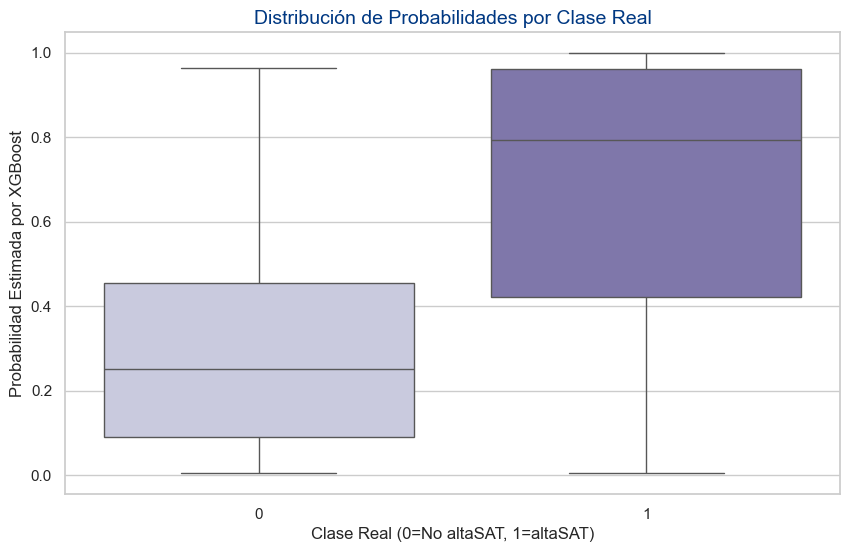

ROC AUC Final en el set de prueba: 0.8184


In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Actual_Target', y='Probabilidad_Evento', data=results_df, palette='Purples')
plt.title('Distribución de Probabilidades por Clase Real', color=BLUE, fontsize=14)
plt.xlabel('Clase Real (0=No altaSAT, 1=altaSAT)')
plt.ylabel('Probabilidad Estimada por XGBoost')
plt.show()

print(f"ROC AUC Final en el set de prueba: {roc_auc_score(y_test, y_probs):.4f}")

---